In [11]:
import pandas as pd

import requests
from urllib.request import urlopen 
from urllib.parse import quote  

import time
import json

import datetime as dt

from concurrent.futures import ThreadPoolExecutor

import nltk

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe

import ast

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
plotly.offline.init_notebook_mode(connected=True)

import sddk

In [ ]:
### to use plotly within browser notebook

#def configure_plotly_browser_state():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [3]:
# spatial packages
import googlemaps
import shapely # geometries, e.g. "POINT (23931.23 45492.17)"
import geopandas # pandas DataFrame + geometry
import contextily as ctx # basemaps

In [4]:
conf = sddk.configure()

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [5]:
key = sddk.read_file("Google_API_key.txt", "str", conf)
gmaps = googlemaps.Client(key=key)
### authorize google sheets

In [12]:
testing_vanlife_df = sddk.read_file("instagram_webscraping/posts_raw_1.json", "df", conf)
testing_vanlife_df.head(2)

,end_cursor,url,text,hashtags,caption,likes,timestamp,location_slug,country_code,coordinates,g_loc_type,i_loc_type
0,QVFCT1dLZGtyQksyekRPUlJ3LVlaTFA0WFdUQ010OE9yNl...,https://www.instagram.com/p/CETwOAgILJK/,Lugares de descanso y pernocta que marcan la d...,"[diasentremontañas, anayruben, subetealpaisaje...","[mountain, sky, outdoor, nature.]",39,2020-08-25 10:17:58,None,None,None,None,None
1,QVFCT1dLZGtyQksyekRPUlJ3LVlaTFA0WFdUQ010OE9yNl...,https://www.instagram.com/p/CETwMNxJWG6/,Pippa's first holibob...and our first camping ...,"[lakedistrict, t5, camping, campervan, hoilday...","[mountain, sky, outdoor, nature.]",31,2020-08-25 10:17:43,lake-district,GB,"{'lat': 35.225172, 'lng': -89.7312158}","[establishment, point_of_interest, shopping_mall]",None


In [13]:
len(testing_vanlife_df)

355

In [15]:
# to use 3-letter version of country codes
# we have to upload some normalized country codes data

country_codes_variants = pd.read_csv("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv")
country_codes_variants.set_index("alpha-2", inplace=True)
country_codes_variants.head(2)

,name,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
alpha-2,,,,,,,,,,
AF,Afghanistan,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
AX,Åland Islands,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN


In [16]:
def column_returner(abbr, column):
    try: return country_codes_variants.at[abbr, column]
    except: return abbr

testing_vanlife_df["country_code_new"] = testing_vanlife_df.apply(lambda row: column_returner(row["country_code"], "alpha-3"), axis=1)
testing_vanlife_df["country"] = testing_vanlife_df.apply(lambda row: column_returner(row["country_code"], "name"), axis=1)
testing_vanlife_df["region"] = testing_vanlife_df.apply(lambda row: column_returner(row["country_code"], "region"), axis=1)
testing_vanlife_df["subregion"] = testing_vanlife_df.apply(lambda row: column_returner(row["country_code"], "sub-region"), axis=1)

testing_vanlife_df.head(2)

,end_cursor,url,text,hashtags,caption,likes,timestamp,location_slug,country_code,coordinates,g_loc_type,i_loc_type,country_code_new,country,region,subregion
0,QVFCT1dLZGtyQksyekRPUlJ3LVlaTFA0WFdUQ010OE9yNl...,https://www.instagram.com/p/CETwOAgILJK/,Lugares de descanso y pernocta que marcan la d...,"[diasentremontañas, anayruben, subetealpaisaje...","[mountain, sky, outdoor, nature.]",39,2020-08-25 10:17:58,None,None,None,None,None,None,None,None,None
1,QVFCT1dLZGtyQksyekRPUlJ3LVlaTFA0WFdUQ010OE9yNl...,https://www.instagram.com/p/CETwMNxJWG6/,Pippa's first holibob...and our first camping ...,"[lakedistrict, t5, camping, campervan, hoilday...","[mountain, sky, outdoor, nature.]",31,2020-08-25 10:17:43,lake-district,GB,"{'lat': 35.225172, 'lng': -89.7312158}","[establishment, point_of_interest, shopping_mall]",None,GBR,United Kingdom of Great Britain and Northern I...,Europe,Northern Europe


In [26]:
type(testing_vanlife_df["hashtags"].tolist()[0])

list

In [35]:
def get_most_popular_hashtags(input_dataframe, column, value, number):
    actual_df = input_dataframe[input_dataframe[column]==value]
    hashtags_list = []
    hashtags_list_of_lists = actual_df["hashtags"].tolist()
    for post_hashatag_list in hashtags_list_of_lists:
        hashtags_list = hashtags_list + post_hashatag_list
    most_frequent = nltk.FreqDist(hashtags_list).most_common(number + 1)
    most_frequent = ["#" + element[0] + " (N=" + str(element[1]) + ")" for element in most_frequent]
    return most_frequent[1:]

In [36]:
get_most_popular_hashtags(testing_vanlife_df, "subregion", "Northern Europe", 5)

['#campervan (N=6)',
 '#roadtrip (N=5)',
 '#camping (N=3)',
 '#travel (N=3)',
 '#outdoor (N=3)']

In [37]:
unique_subregions = [subr for subr in testing_vanlife_df["subregion"].unique() if (subr != None) and (subr != "")]
unique_subregions

['Northern Europe',
 'Northern America',
 'Western Europe',
 'Australia and New Zealand',
 'Southern Europe',
 'Eastern Europe',
 'Eastern Asia',
 'Southern Asia',
 'Western Asia',
 'Central Asia',
 'Sub-Saharan Africa',
 'South-eastern Asia']

In [43]:
hashtags_subregion = []
for element in unique_subregions:
    hashtags_subregion.append([element] + get_most_popular_hashtags(testing_vanlife_df, "subregion", element, 5))

hashtags_subregion_df = pd.DataFrame(hashtags_subregion)
hashtags_subregion_df.set_index(0, inplace=True)
hashtags_subregion_df

,1,2,3,4,5
0,,,,,
Northern Europe,#campervan (N=6),#roadtrip (N=5),#camping (N=3),#travel (N=3),#outdoor (N=3)
Northern America,#roadtrip (N=2),#vanlifers (N=2),#vanlifestyle (N=2),#pikespeak (N=2),#camper (N=1)
Western Europe,#campervan (N=11),#nature (N=9),#roadtrip (N=8),#france (N=8),#travel (N=6)
Australia and New Zealand,#roadtrip (N=4),#australia (N=4),#sonyalpha (N=4),#seeaustralia (N=3),#nature (N=3)
Southern Europe,#campervan (N=7),#vanlifediaries (N=6),#roadtrip (N=4),#camper (N=4),#vanlifeexplorers (N=3)
Eastern Europe,#camper (N=2),#campervan (N=2),#czeskiraj (N=2),#camping (N=1),#travelling (N=1)
Eastern Asia,#テント泊#キャンプギア#湖畔キャンプ#吊り橋効果 (N=1),#garagebar1961 (N=1),#ガレージバー1961 (N=1),#ogchi (N=1),#yokohama (N=1)
Southern Asia,#vans (N=1),#vansoldskool (N=1),#vansoffthewall (N=1),#jordans (N=1),#jordan4 (N=1)
Western Asia,#travel (N=3),#lifestyle (N=2),#adventure (N=2),#nature (N=2),#roadtrip (N=2)


In [45]:
unique_regions = [reg for reg in testing_vanlife_df["region"].unique() if (reg != None) and (reg != "")]

hashtags_region = []
for element in unique_regions:
  hashtags_region.append([element] + get_most_popular_hashtags(testing_vanlife_df, "region", element, 5))

hashtags_region_df = pd.DataFrame(hashtags_region)
hashtags_region_df.set_index(0, inplace=True)
hashtags_region_df

,1,2,3,4,5
0,,,,,
Europe,#campervan (N=26),#roadtrip (N=17),#vanlifediaries (N=15),#nature (N=14),#travel (N=13)
Americas,#roadtrip (N=2),#vanlifers (N=2),#vanlifestyle (N=2),#pikespeak (N=2),#camper (N=1)
Oceania,#roadtrip (N=4),#australia (N=4),#sonyalpha (N=4),#seeaustralia (N=3),#nature (N=3)
Asia,#travel (N=5),#camping (N=3),#kerala (N=3),#instagood (N=3),#love (N=3)
Africa,#positivethinking (N=1),#positivevibes (N=1),#positivity (N=1),#motivation (N=1),#positivequotes (N=1)


In [46]:
# to use 3-letter version of country codes
# we have to upload some normalized country codes data

country_codes_variants = pd.read_csv("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv")
country_codes_variants.set_index("alpha-2", inplace=True)
country_codes_variants.head(2)

,name,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
alpha-2,,,,,,,,,,
AF,Afghanistan,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
AX,Åland Islands,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN


In [47]:
hashtags_list = []
hashtags_list_of_lists = testing_vanlife_df["hashtags"].tolist()
for post_hashtags in hashtags_list_of_lists:
  hashtags_list.extend(post_hashtags)
print(hashtags_list[:100])

['diasentremontañas', 'anayruben', 'subetealpaisaje', 'ruteandolavida#viajar', 'travel', 'travelphotography', 'autocaravana', 'mountain', 'montañas', 'trekking', 'senderismo', 'naturelovers', 'viajarebautocaravana', 'vanlife', 'autocaravaning', 'perros', 'dog', 'perrosdeinstagram', 'bordercollie', 'perrosfelices', 'bergerdepyrenees', 'perrosenautocaravana', 'rutasenautocaravana', 'autocaravanaknaus', 'autocaravanabenimar', 'lakedistrict', 't5', 'camping', 'campervan', 'hoilday', 'vanlife', 'travel', 'travelgram', 'cockerpoosofinstagram', 'cockapooclub', 'puppyoftheday', 'cockapoo', 'cockerpoolife', 'cockapoocorner', 'instadogs', 'instapuppy', 'vanlife', 'camper', 'vwt', 'camping', 'homeiswhereyouparkit', 'camperlife', 't', 'travel', 'vanlifediaries', 'van', 'roadtrip', 'vw', 'campervanlife', 'homeonwheels', 'vanlifers', 'adventure', 'vanconversion', 'vwbus', 'camperlifestyle', 'volkswagen', 'projectvanlife', 'vanlifestyle', 'wanderlust', 'vwcamper', 'vanlifegermany', 'vanlifemovement',

In [107]:
nltk.FreqDist(hashtags_list).most_common(30)

[('vanlife', 278),
 ('campervan', 85),
 ('travel', 55),
 ('roadtrip', 50),
 ('camping', 45),
 ('nature', 45),
 ('camper', 37),
 ('homeiswhereyouparkit', 37),
 ('vanlifediaries', 34),
 ('camperlife', 29),
 ('van', 29),
 ('vanlifestyle', 26),
 ('vanlifegermany', 26),
 ('vanconversion', 24),
 ('vanlifers', 23),
 ('camping,', 23),
 ('outback,', 23),
 ('4x4,', 23),
 ('4wd,', 23),
 ('4wdaustralia,', 23),
 ('caravan,', 23),
 ('offroad,', 23),
 ('offroadcaravan,', 23),
 ('greynomads,', 23),
 ('vanlife,', 23),
 ('trek,', 23),
 ('walk,', 23),
 ('hike,', 23),
 ('holiday,', 23),
 ('nature,', 23)]

# Exploring spatial aspects

In [63]:
testing_vanlife_short["coordinates"].tolist()[1]

-89.7312158

In [73]:
df_geo = testing_vanlife_df[testing_vanlife_df["coordinates"].notnull()]
df_geo["y"] = df_geo.apply(lambda row: row["coordinates"]["lat"], axis=1)
df_geo["x"] = df_geo.apply(lambda row: row["coordinates"]["lng"], axis=1)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [78]:
gdf = geopandas.GeoDataFrame(df_geo, geometry=geopandas.points_from_xy(df_geo["x"], df_geo["y"]))
gdf.drop(["coordinates", "x", "y"], axis=1, inplace=True)
gdf

,end_cursor,url,text,hashtags,caption,likes,timestamp,location_slug,country_code,g_loc_type,i_loc_type,country_code_new,country,region,subregion,geometry
1,QVFCT1dLZGtyQksyekRPUlJ3LVlaTFA0WFdUQ010OE9yNl...,https://www.instagram.com/p/CETwMNxJWG6/,Pippa's first holibob...and our first camping ...,"[lakedistrict, t5, camping, campervan, hoilday...","[mountain, sky, outdoor, nature.]",31,2020-08-25 10:17:43,lake-district,GB,"[establishment, point_of_interest, shopping_mall]",None,GBR,United Kingdom of Great Britain and Northern I...,Europe,Northern Europe,POINT (-89.73122 35.22517)
2,QVFCT1dLZGtyQksyekRPUlJ3LVlaTFA0WFdUQ010OE9yNl...,https://www.instagram.com/p/CETwJWGpuv9/,#vanlife #camper #vwt #camping #homeiswhereyou...,"[vanlife, camper, vwt, camping, homeiswhereyou...",[indoor.],65,2020-08-25 10:17:19,los-angeles-california,US,"[locality, political]",city,USA,United States of America,Americas,Northern America,POINT (-118.24368 34.05223)
3,QVFCT1dLZGtyQksyekRPUlJ3LVlaTFA0WFdUQ010OE9yNl...,https://www.instagram.com/p/CETwJONA_9T/,Back to work today and missing the sea views b...,"[vanlife, vanlifediaries, vanlifeuk, t4, vwt4,...","[one or more people, ocean, sky, cloud, outdoo...",56,2020-08-25 10:17:18,wales,GB,"[administrative_area_level_1, political]",region,GBR,United Kingdom of Great Britain and Northern I...,Europe,Northern Europe,POINT (-3.78371 52.13066)
4,QVFCT1dLZGtyQksyekRPUlJ3LVlaTFA0WFdUQ010OE9yNl...,https://www.instagram.com/p/CETwIInpCsg/,Being back in Norway meant shitty weather and ...,"[norway, hike, waterfall, lake, travel, view, ...","[mountain, sky, outdoor, nature.]",19,2020-08-25 10:17:09,rago-national-park,,"[establishment, park, point_of_interest, touri...",None,,,,,POINT (16.00568 67.43851)
5,QVFCT1dLZGtyQksyekRPUlJ3LVlaTFA0WFdUQ010OE9yNl...,https://www.instagram.com/p/CETwHu_jlIo/,Visite de Rocamadour au top !! #rocamadour #d...,"[rocamadour, decouverte, campingcar, campingca...","[cloud, sky, outdoor.]",19,2020-08-25 10:17:06,rocamadour-france,FR,"[locality, political]",city,FRA,France,Europe,Western Europe,POINT (1.61790 44.79938)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,QVFCVEFIVU4tWDluVjZuVXN4RHhjd1ZpREh1VWpJQ0ZhZ0...,https://www.instagram.com/p/CETqyT2hnya/,Not a bad vibe to get you through your week S...,"[caravanandcampingwa, caravanwa, campingwa, le...","[ocean, sky, water, beach, outdoor, nature.]",81,2020-08-25 09:30:29,wilbinga,AU,"[locality, political]",city,AUS,Australia,Oceania,Australia and New Zealand,POINT (115.60711 -31.39932)
348,QVFCVEFIVU4tWDluVjZuVXN4RHhjd1ZpREh1VWpJQ0ZhZ0...,https://www.instagram.com/p/CETqvPLg0w3/,Tu es plutt camping-car ou van amnag pour tes ...,"[camping, van, vanlife, camplife, campsite, be...","[tree, sky, outdoor, nature.]",14,2020-08-25 09:30:23,carqueiranne,FR,"[locality, political]",city,FRA,France,Europe,Western Europe,POINT (6.07228 43.09678)
349,QVFCVEFIVU4tWDluVjZuVXN4RHhjd1ZpREh1VWpJQ0ZhZ0...,https://www.instagram.com/p/CETqxVZJNhn/,"Turismo familiar, de proximidad y dogfriendly ...","[campings,, dogfriendly, Teruel, Beceite, vald...","[one or more people, sky, outdoor, text, nature.]",227,2020-08-25 09:30:21,matarrana,ES,"[administrative_area_level_3, political]",None,ESP,Spain,Europe,Southern Europe,POINT (0.07468 40.87783)
350,QVFCVEFIVU4tWDluVjZuVXN4RHhjd1ZpREh1VWpJQ0ZhZ0...,https://www.instagram.com/p/CETqvCjJyDh/,First #roadtrip with @2beealives sister. The r...,"[roadtrip, vanlife, vanlifegermany, vanlifedia...","[sky, tree, plant, grass, outdoor, nature.]",35,2020-08-25 09:30:02,pirna-germany,DE,"[locality, political]",city,DEU,Germany,Europe,Western Europe,POINT (13.94192 50.96252)


In [105]:
selection = gdf[gdf["subregion"]=="Western Europe"]

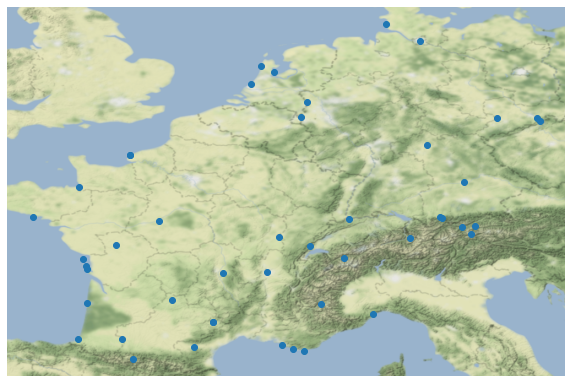

In [106]:
fig, ax = plt.subplots(figsize=(10,10))
selection.plot(ax=ax)
ctx.add_basemap(ax, zoom=6, url=getattr(ctx.sources, "ST_TERRAIN_BACKGROUND"), crs="epsg:4326")
plt.axis("off")
plt.show()

# Backup

In [0]:
help(plotly.offline.plot)

Help on function plot in module plotly.offline.offline:

plot(figure_or_data, show_link=False, link_text='Export to plot.ly', validate=True, output_type='file', include_plotlyjs=True, filename='temp-plot.html', auto_open=True, image=None, image_filename='plot_image', image_width=800, image_height=600, config=None, include_mathjax=False)
    Create a plotly graph locally as an HTML document or string.
    
    Example:
    ```
    from plotly.offline import plot
    import plotly.graph_objs as go
    
    plot([go.Scatter(x=[1, 2, 3], y=[3, 2, 6])], filename='my-graph.html')
    # We can also download an image of the plot by setting the image parameter
    # to the image format we want
    plot([go.Scatter(x=[1, 2, 3], y=[3, 2, 6])], filename='my-graph.html'
         image='jpeg')
    ```
    More examples below.
    
    figure_or_data -- a plotly.graph_objs.Figure or plotly.graph_objs.Data or
                      dict or list that describes a Plotly graph.
                      See h

# Tag Frequencies & Population & GDP

In [108]:
countries_tag_df = pd.DataFrame(testing_vanlife_df.groupby("country_code").size())
countries_tag_df.reset_index(inplace=True)
countries_tag_df.columns = ["country_code", "tag_frequency"]
countries_tag_df.head(2)

,country_code,tag_frequency
0,,24
1,AE,2


In [109]:
# to use 3-letter version of country codes
# we have to upload some normalized country codes data

country_codes_variants = pd.read_csv("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv")
country_codes_variants.set_index("alpha-2", inplace=True)
country_codes_variants.head(2)

,name,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
alpha-2,,,,,,,,,,
AF,Afghanistan,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
AX,Åland Islands,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN


In [ ]:
world_population_df = pd.read_csv("https://raw.githubusercontent.com/datasets/population/master/data/population.csv")
world_population_df.head(2)
world_population_2016_df = world_population_df[world_population_df["Year"]==2016]
world_population_2016_df.set_index("Country Code", inplace=True)
world_population_2016_df.head(2)

In [ ]:
world_population_2016_df.at["ARB", "Value"]

In [ ]:
world_population_2016_df

In [112]:
### add the 3-letters version and country names into our dataset

def three_letters_abbr_returner(abbr):
  try: return country_codes_variants.at[abbr, "alpha-3"]
  except: return abbr

def country_name_returner(abbr):
  try: return country_codes_variants.at[abbr, "name"]
  except: return ""
  
def population_value_returner(abbr):
  try: return world_population_2016_df.at[abbr, "Value"]
  except: return ""
  
def tag_frequency_normalized(row_data):
  try: return float(float(row_data["tag_frequency"]) / float(row_data["population"]))
  except: return 0
  
countries_tag_df["country_code_new"] = countries_tag_df.apply(lambda row: three_letters_abbr_returner(row["country_code"]), axis=1)
countries_tag_df["country"] = countries_tag_df.apply(lambda row: country_name_returner(row["country_code"]), axis=1)
countries_tag_df["population"] = countries_tag_df.apply(lambda row: population_value_returner(row["country_code_new"]), axis=1)
countries_tag_df["tag_frequency_normalized"] = countries_tag_df.apply(lambda row: tag_frequency_normalized(row), axis=1)

countries_tag_df.head(5)

,country_code,tag_frequency,country_code_new,country,population,tag_frequency_normalized
0,,24,,,,0.000000e+00
1,AE,2,ARE,United Arab Emirates,9360980,2.136528e-07
2,AT,3,AUT,Austria,8736668,3.433803e-07
3,AU,15,AUS,Australia,24190907,6.200677e-07
4,BG,1,BGR,Bulgaria,7127822,1.402953e-07


In [0]:
configure_plotly_browser_state()

# based on this: https://plot.ly/python/choropleth-maps/

data = [go.Choropleth(
    locations = countries_tag_df['country_code_new'],
    z = countries_tag_df["tag_frequency"],
    text = countries_tag_df['country'],
    colorscale = [
        [0, "rgb(5, 10, 172)"],
        [0.35, "rgb(40, 60, 190)"],
        [0.5, "rgb(70, 100, 245)"],
        [0.6, "rgb(90, 120, 245)"],
        [0.7, "rgb(106, 137, 247)"],
        [1, "rgb(220, 220, 220)"]
    ],
    autocolorscale = True,
    reversescale = False,
    marker = go.choropleth.Marker(
        line = go.choropleth.marker.Line(
            color = 'rgb(180,180,180)',
            width = 0.5
        )),
    colorbar = go.choropleth.ColorBar(
        tickprefix = 'N=',
        title = 'posts'),
)]

layout = go.Layout(
    title = go.layout.Title(
        text = '#vanlife on May 6'
    ),
    geo = go.layout.Geo(
        showland = True,
        landcolor = "rgb(212, 212, 212)",
        showframe = False,
        showcoastlines = True,
        projection = go.layout.geo.Projection(
            type = 'equirectangular'
        )
    ),
    annotations = [go.layout.Annotation(
        x = 0.55,
        y = 0.1,
        xref = 'paper',
        yref = 'paper',
        text = 'Data mined from Instagram',
        showarrow = False
    )]
)

fig = go.Figure(data = data, layout = layout)
iplot(fig, filename = 'd3-world-map')

In [0]:
configure_plotly_browser_state()

# based on this: https://plot.ly/python/choropleth-maps/

data = [go.Choropleth(
    locations = countries_tag_df['country_code_new'],
    z = countries_tag_df["tag_frequency_normalized"],
    text = countries_tag_df['country'],
    colorscale = [
        [0, "rgb(5, 10, 172)"],
        [0.35, "rgb(40, 60, 190)"],
        [0.5, "rgb(70, 100, 245)"],
        [0.6, "rgb(90, 120, 245)"],
        [0.7, "rgb(106, 137, 247)"],
        [1, "rgb(220, 220, 220)"]
    ],
    autocolorscale = True,
    reversescale = False,
    marker = go.choropleth.Marker(
        line = go.choropleth.marker.Line(
            color = 'rgb(180,180,180)',
            width = 0.5
        )),
    colorbar = go.choropleth.ColorBar(
        tickprefix = 'N=',
        title = 'posts'),
)]

layout = go.Layout(
    title = go.layout.Title(
        text = '#vanlife on May 6'
    ),
    geo = go.layout.Geo(
        showframe = False,
        showcoastlines = False,
        projection = go.layout.geo.Projection(
            type = 'equirectangular'
        )
    ),
    annotations = [go.layout.Annotation(
        x = 0.55,
        y = 0.1,
        xref = 'paper',
        yref = 'paper',
        text = 'Data mined from Instagram',
        showarrow = False
    )]
)

fig = go.Figure(data = data, layout = layout)
iplot(fig, filename = 'd3-world-map')

# Population & GDP

In [0]:
world_population_df = pd.read_csv("https://raw.githubusercontent.com/datasets/population/master/data/population.csv")
world_population_df.head(2)
world_population_2016_df = world_population_df[world_population_df["Year"]==2016]
world_population_2016_df.set_index("Country Code", inplace=True)
world_population_2016_df.head(2)

,Country Name,Year,Value
Country Code,,,
ARB,Arab World,2016,406452690.0
CSS,Caribbean small states,2016,7245472.0


In [0]:
world_gdp_df = pd.read_csv("https://raw.githubusercontent.com/datasets/gdp/master/data/gdp.csv")
world_gdp_df.head(2)

,Country Name,Country Code,Year,Value
0,Arab World,ARB,1968,2.576068e+10
1,Arab World,ARB,1969,2.843420e+10


In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')
df.head(2)

,COUNTRY,GDP (BILLIONS),CODE
0,Afghanistan,21.71,AFG
1,Albania,13.40,ALB


In [0]:
configure_plotly_browser_state()

data = [go.Choropleth(
    locations = df['CODE'],
    z = df['GDP (BILLIONS)'],
    text = df['COUNTRY'],
    colorscale = [
        [0, "rgb(5, 10, 172)"],
        [0.35, "rgb(40, 60, 190)"],
        [0.5, "rgb(70, 100, 245)"],
        [0.6, "rgb(90, 120, 245)"],
        [0.7, "rgb(106, 137, 247)"],
        [1, "rgb(220, 220, 220)"]
    ],
    autocolorscale = False,
    reversescale = True,
    marker = go.choropleth.Marker(
        line = go.choropleth.marker.Line(
            color = 'rgb(180,180,180)',
            width = 0.5
        )),
    colorbar = go.choropleth.ColorBar(
        tickprefix = '$',
        title = 'GDP<br>Billions US$'),
)]

layout = go.Layout(
    title = go.layout.Title(
        text = '2014 Global GDP'
    ),
    geo = go.layout.Geo(
        showframe = False,
        showcoastlines = False,
        projection = go.layout.geo.Projection(
            type = 'equirectangular'
        )
    ),
    annotations = [go.layout.Annotation(
        x = 0.55,
        y = 0.1,
        xref = 'paper',
        yref = 'paper',
        text = 'Source: <a href="https://www.cia.gov/library/publications/the-world-factbook/fields/2195.html">\
            CIA World Factbook</a>',
        showarrow = False
    )]
)

fig = go.Figure(data = data, layout = layout)
iplot(fig, filename = 'd3-world-map')